In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# задаем путь к данным
path = 'https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv'

In [3]:
# создаем датафрейм
df = pd.read_csv(path, sep=';')

In [4]:
# смотрим что все загрузилось корректно
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
# проверяем на NaN
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [6]:
# смотрим типы данных колонок
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [7]:
# заменяем запятые на точки для последующего перевода колонки в тип float
df.value = df.value.apply(lambda x: x.replace(',','.'))
# приводим к типу float колонку со значениями
df.value = df.value.astype(float)

In [8]:
# удаляем лишнюю колонку
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [10]:
# создаем 2 датафрейма с выборками контрольной группы и тестовой
control = df.query('experimentVariant == "Control"')
test = df.query('experimentVariant == "Treatment"')

In [11]:
# смотрим экспресс анализ значений value в контрольной группе
control.describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


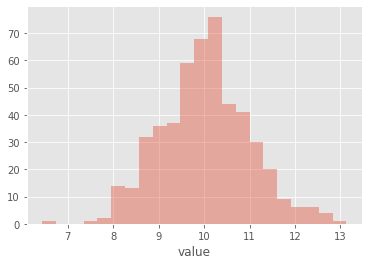

In [12]:
# посмотрим на распределение
# видим что распределение контрольной группы нормальное
sns.distplot(control.value, kde=False)

In [13]:
# смотрим экспресс анализ значений value в тестовой группе
test.describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


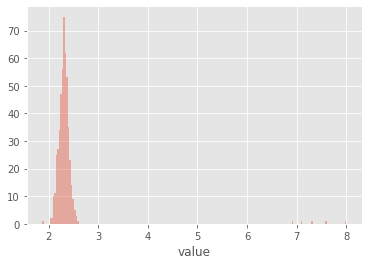

In [14]:
# распределение тестовой группы сложно оценить без логарифмирования значений
# видим что распределение также нормальное но имее значительные выбросы о которых я ранее говорил
sns.distplot(np.log(test.value), kde=False, bins = 200)

In [15]:
# посмотрим на топ-30 самых высоких значений
# видим, что топ-5 значений имеют аномально высокие значения
# более того, сами значения целые без характерного для остальных значений формата точности
# порядковые номера значений идут друг за другом
# очень высока вероятность, что значения не являются истинными и связаны с ошибкой в данных!
test.value.sort_values(ascending=False).head(30)

999    3000.000000
998    2000.000000
997    1500.000000
996    1200.000000
995    1000.000000
671      13.130346
695      12.817541
794      12.728285
863      12.663784
719      12.598569
915      12.511711
974      12.488277
511      12.389786
875      12.340248
940      12.241951
887      12.235453
772      12.200294
632      12.161718
517      12.155807
888      11.998758
742      11.990394
874      11.923804
801      11.907292
984      11.889777
698      11.878479
577      11.790290
668      11.768767
684      11.729077
894      11.704867
635      11.660388
Name: value, dtype: float64

Первый вывод: \
Распределение трафика в группах одинаковое (кол-во наблюдений).\
Распределения в обоих группах нормальное, но в тестовой группе есть значительные выбросы справа. \
Квантили близки по значениям в обоих группах.\
Минимальное значение одинаково.\
Максимальное значение в тестовой группе аномально высокое - что привело к существенному сдвигу среднего.

In [16]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
# функция из лекции с небольшими дополнениями
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    u_test = mannwhitneyu(samples_1, samples_2)    
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "u_test": u_test}

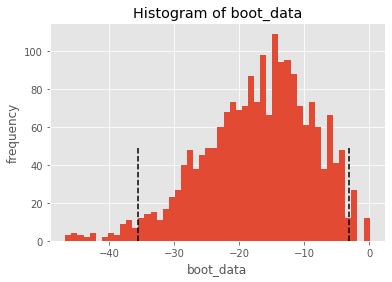

In [17]:
# в результате хранится разница двух распределений, ДИ и pvalue для bootstrap по средним
booted_data_mean = get_bootstrap(control.value, 
                                 test.value, 
                                 boot_it = 2000, 
                                 statistic = np.mean)

In [18]:
# p_value для bootstrap по разницам значений средних
# можно считать статистически значимыми различия между группами (p_value < 0.05)
booted_data_mean["p_value"]

0.04243486441646911

In [19]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# И в этот раз значение p-value (> 0.05) говорит о том, что мы не можем отклонить нулевую гипотезу
booted_data_mean['u_test']

MannwhitneyuResult(statistic=118783.5, pvalue=0.17345553341282216)

In [20]:
# диапазон 95% распределения разниц
# значение 0 за пределами 95% диапазона:
# казалось бы есть значимые различия
booted_data_mean["ci"]

,0
0.025,-35.575499
0.975,-3.109860


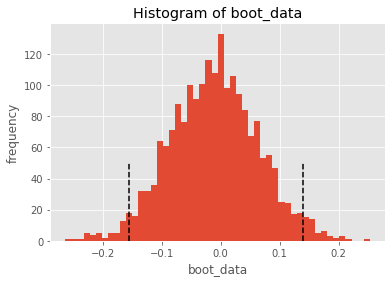

In [21]:
# в результате хранится разница двух распределений, ДИ и pvalue для медианного bootstrap
booted_data_median = get_bootstrap(control.value,
                                   test.value, 
                                   boot_it = 2000,
                                   statistic = np.median)

In [22]:
# p_value для bootstrap по разницам значений медиан
# различия между группами можно считать статистически незначимыми p_value > 0.05
booted_data_median["p_value"]

0.88293662787521

In [23]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# значение p-value (> 0.05) говорит о том что мы не можем отклонить нулевую гипотезу
booted_data_median["u_test"]

MannwhitneyuResult(statistic=123548.5, pvalue=0.7506814854409315)

In [24]:
# диапазон 95% распределения разниц
# значение 0 находится в диапазоне разниц
booted_data_median["ci"]

,0
0.025,-0.154813
0.975,0.138852


In [25]:
# тест Мана-Уитни, но для выборок без бутстрапа
# аналогично p_value > 0.05 говорит о том, что значимых различий в выборках нет
stat, p = mannwhitneyu(control.value, test.value)
stat, p

(124189.5, 0.8592148582485579)

Выводы:
1. Проверка бутстрапом и тестом Мана-Уитни подтвердили догадки, которые появились при предварительном анализе. Значимых различий в выборках нет.
2. Разница в методах проверки бутстрапом по средним и медианам существенна (для этих данных). Бутстрап по средним ввиду наличия аномальных выбросов в тестовой группе привел к получению вывода о значимых различиях (p_value < 0.05).
3. Но применив непараметрический тест Мана-Уитни*, значимые различия не подтвердились в обоих случаях: и по средним и по медианам. 
*Непараметрический тест ранжирует значения, не учитывая фактические значения.
4. Тест Мана-Уитни к чистым данным по группам также не подтверждает наличия значимых различий.
5. Проверить значения аномальных выбросов в тестовой группе на истину(корректность).

Другими словами: для того, чтобы быть уверенным в корректности анализа выборок, необходимо проводить различные тесты. Как по средним, так и по медианам. В т.ч. с использованием непараметрических тестов.
Если все проверки докажут наличие значимых различий (p-value < 0.05 например), то можно принимать альтернативную гипотезу